# Problem Set 4

A small guide for problem set 4 part 2.
Please refer to the updated version of the problem set for some more information.
The overall goal is to predict units sold from prices (and potentially other features). The main objectives:

1. Compare blackbox-ML and discrete choice approaches

2. Meaningful feature engineering / inclusion (we don't expect anything crazy here). *Think about what makes you choose between different products in a supermarket given their prices*.
3. Evaluation of Models. But with the right perspective. How can you evaluate which of given two models performs better for a given use case? *Imagine that your client is a producer in the category you have chosen
and uses your models to evaluate different scenarios, on the basis of which he
will negotiate prices with Dominick's.*


This problem set is not about how well the models are implemented, in terms of the correct or optimal choice of model parameters etc., but rather the modelling of a use case and how the lense / approach on that use case is presented/motivated through the explanatory data analysis, feature selection and engineering and model evaluation. Moreover it is an practical implementation of the content taught in the guest lecture, and you should demonstrate the implications of this lecture, especially in comparison between blackbox-ML and discrete choice models.

Below I provide some very basic starting points and useful references.

### Import libraries

In [90]:
import pandas as pd

### Data

Pick a category-level dataset from the Dominick's dataset to be found here. Which category you choose is up to you, but ideally the dataset should contain some variation in prices over time (e.g. promotions in some weeks).

In [148]:
# Slise the data to be able to run it
df = pd.read_csv('data/wcig.csv')
#df = df[(df.WEEK>=100) & (df.WEEK<=220)]
df = df[df.PRICE != 0]
df = df[df.WEEK<=200]
df.to_csv('data/wcig_slised.csv')

/var/folders/k_/pt0pmhm97jx4hphkj9n4303w0000gn/T/ipykernel_52865/2752446584.py:2: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/wcig.csv')


In [149]:
# Load movement data
 
df = pd.read_csv('data/wcig_slised.csv', index_col=0)
df.head()

/var/folders/k_/pt0pmhm97jx4hphkj9n4303w0000gn/T/ipykernel_52865/2554955510.py:3: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/wcig_slised.csv', index_col=0)


,STORE,UPC,WEEK,MOVE,QTY,PRICE,SALE,PROFIT,OK,PRICE_HEX,PROFIT_HEX
1,8,190,195,2,1,21.51,NaN,50.49,1,4035828F5C28F5C3,40493EB851EB851F
77,21,190,195,1,1,2.00,NaN,22.86,1,4000000000000000,4036DC28F5C28F5C
153,32,190,195,2,1,21.51,NaN,50.49,1,4035828F5C28F5C3,40493EB851EB851F
154,32,190,196,1,1,21.51,NaN,50.49,1,4035828F5C28F5C3,40493EB851EB851F
156,32,190,198,1,1,21.51,NaN,50.48,1,4035828F5C28F5C3,40493D70A3D70A3D


In [150]:
df.shape

(818084, 11)

In [151]:
# Load UPC data - not sure if need this one, but left it here just in case for now

df_upc = pd.read_csv('data/upccig.csv', encoding='latin-1')
df_upc.head()

,COM_CODE,UPC,DESCRIP,SIZE,CASE,NITEM
0,700,190,KING CARTON CIGS (PL,1 CT,1,86040
1,700,191,100'S CARTON CIGS (P,1 CT,1,86060
2,705,193,25 CT SINGLE PACK CI,1 CT,8,80080
3,705,194,GENERIC SINGLE,1 CT,10,80020
4,700,195,KING CARTON PRICE VA,1 CT,1,86050


Note that this only is one part of the data,
to include further information please download the respective datasets and merge them by the correct variable (UPC for products), which might be useful for creating more meaningful features.

### EDA

Perform an exploratory data analysis to familiarise yourself with the data.

In [152]:
df.dtypes #some variables need transformation

STORE           int64
UPC             int64
WEEK            int64
MOVE            int64
QTY             int64
PRICE         float64
SALE           object
PROFIT        float64
OK              int64
PRICE_HEX      object
PROFIT_HEX     object
dtype: object

In [153]:
df.describe()

,STORE,UPC,WEEK,MOVE,QTY,PRICE,PROFIT,OK
count,818084.000000,8.180840e+05,818084.000000,818084.000000,818084.0,818084.000000,818084.000000,818084.000000
mean,82.674376,1.608730e+09,119.079692,14.325881,1.0,9.288452,43.093056,0.988821
std,35.862787,7.155218e+08,52.715598,110.038988,0.0,8.190906,15.790555,0.105136
min,2.000000,1.900000e+02,1.000000,1.000000,1.0,0.500000,-93.980000,0.000000
25%,54.000000,1.230000e+09,89.000000,1.000000,1.0,2.280000,31.430000,1.000000
50%,88.000000,1.230012e+09,125.000000,2.000000,1.0,2.590000,39.200000,1.000000
75%,112.000000,2.610000e+09,162.000000,5.000000,1.0,17.830000,50.000000,1.000000
max,139.000000,2.720000e+09,200.000000,7111.000000,1.0,250.000000,97.610000,1.000000


In [154]:
df.SALE.unique() # might contain more values for different categories

array([nan, 'S'], dtype=object)

In [155]:
# df['SALE'] = df['SALE'].apply(lambda x: 0 if pd.isna(x) else 1)
df = pd.get_dummies(df, columns=["SALE"], dummy_na=False)

As each category contains a lot of data, it might be helpful to select a subsample of the data. This means focusing on a reduced number of products, stores or time period or any combination of these. How the subsample is created depends on the intended use case and therefore should include considerations on the validity of the use case.
For instance one could focus on selecting similar stores or similar products.


In my case, that is just used to showcase some basic implementation and ideas I will focus on the most profitable products across the most profitable stores (which probably is not the best way to go!!!)

In [156]:
# select most profitable stores
store_winners = df.groupby("STORE")["PROFIT"].sum().sort_values(ascending=False)[:5].index
# subset
subset_df = df[df['STORE'].isin(store_winners)]

In [157]:
# select most profitable products for most profitable stores
product_winners = subset_df.groupby("UPC")["PROFIT"].sum().sort_values(ascending=False)[:5].index
subset_df = subset_df[subset_df['UPC'].isin(product_winners)]

In [158]:
subset_df.head()

,STORE,UPC,WEEK,MOVE,QTY,PRICE,PROFIT,OK,PRICE_HEX,PROFIT_HEX,SALE_S
34812,80,194,1,24,1,1.49,67.38,1,3FF7D70A3D70A3D7,4050D851EB851EB8,0
34813,80,194,2,29,1,1.49,67.38,1,3FF7D70A3D70A3D7,4050D851EB851EB8,0
34814,80,194,3,24,1,1.49,67.38,1,3FF7D70A3D70A3D7,4050D851EB851EB8,0
34815,80,194,4,23,1,1.49,67.38,1,3FF7D70A3D70A3D7,4050D851EB851EB8,0
34816,80,194,5,41,1,1.49,67.38,1,3FF7D70A3D70A3D7,4050D851EB851EB8,0


In [159]:
# check for some variation of prices through offers across products.
subset_df.groupby("UPC")["SALE_S"].mean()

UPC
194           0.0
197           0.0
1230011013    0.0
1230011113    0.0
1230019013    0.0
Name: SALE_S, dtype: float64

### EDA - Plots

Please use this just as a starting idea. The plots presented here are by no means complete, neither done with a great deal of care. While I won't grade the beauty of the presented EDA, it is important that the implications of the EDA relate to the chosen use case and the later model implementations

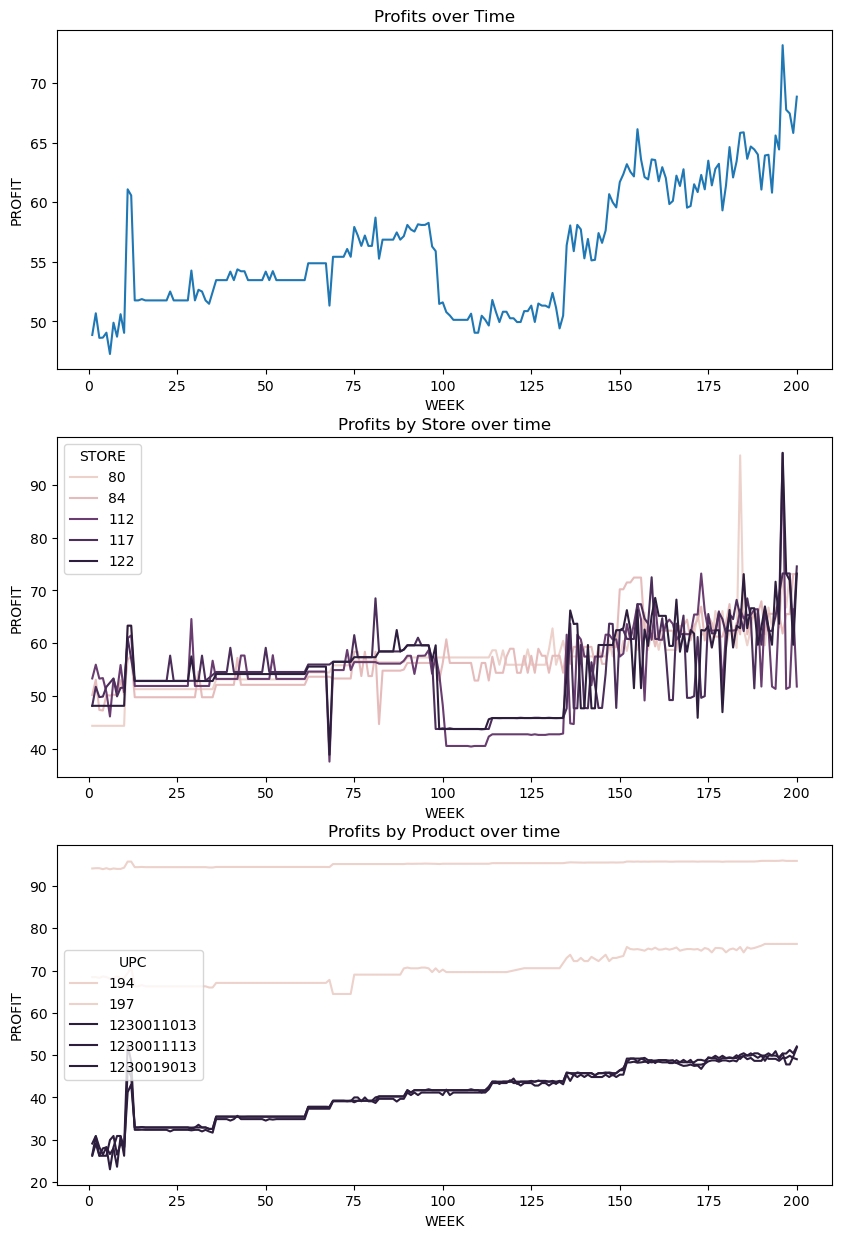

In [160]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(3,1, figsize=(10,15))
sns.lineplot(subset_df, x="WEEK", y="PROFIT", errorbar=None, ax=ax[0])
ax[0].set_title("Profits over Time")
sns.lineplot(subset_df, x="WEEK", y="PROFIT", hue="STORE",errorbar=None, ax=ax[1])
ax[1].set_title("Profits by Store over time")
sns.lineplot(subset_df, x="WEEK", y="PROFIT", hue="UPC",errorbar=None, ax=ax[2])
ax[2].set_title("Profits by Product over time")
plt.show()

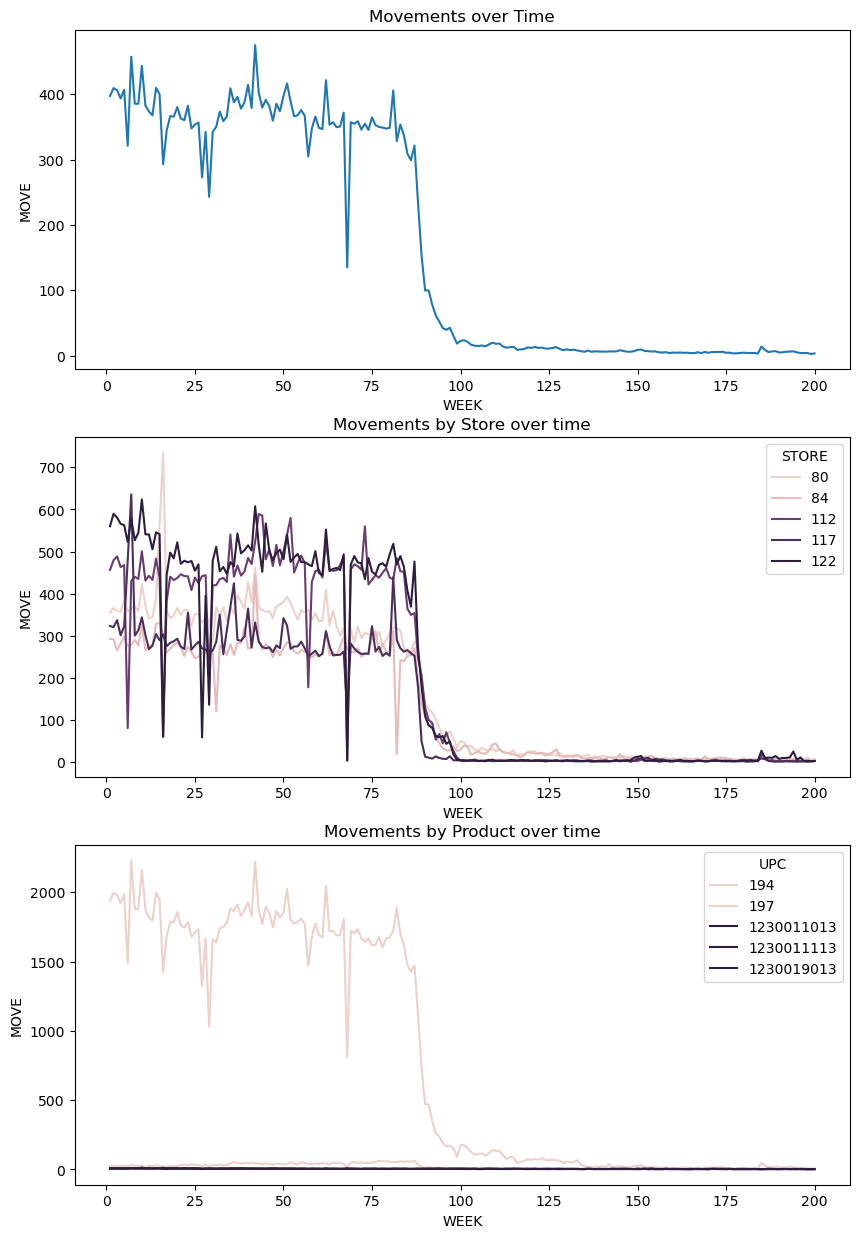

In [161]:
fig, ax = plt.subplots(3,1, figsize=(10,15))
sns.lineplot(subset_df, x="WEEK", y="MOVE", errorbar=None, ax=ax[0])
ax[0].set_title("Movements over Time")
sns.lineplot(subset_df, x="WEEK", y="MOVE", hue="STORE",errorbar=None, ax=ax[1])
ax[1].set_title("Movements by Store over time")
sns.lineplot(subset_df, x="WEEK", y="MOVE", hue="UPC",errorbar=None, ax=ax[2])
ax[2].set_title("Movements by Product over time")
plt.show()

Not the most informative, but there is a lot of variation in prices

In [162]:
!pip3 install cmocean


[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [163]:
import cmocean
cpal = sns.color_palette("cmo.deep", n_colors=5)
sns.barplot(subset_df, x="STORE", y="PROFIT", hue="UPC", palette= cpal)
plt.show()

ModuleNotFoundError: No module named 'cmocean'

In [118]:
cpal = sns.color_palette("cmo.deep", n_colors=2)
fig, ax = plt.subplots(2,1)
sns.barplot(subset_df, x="STORE", y="MOVE", hue="SALE_B", palette= cpal, ax=ax[0])
sns.barplot(subset_df, x="STORE", y="PROFIT", hue="SALE_B", palette=cpal, ax=ax[1])
plt.show()

ValueError: 'cmo.deep' is not a valid palette name

### Feature Selection and Engineering

This is not a problemt set on how to correctly select and engineer features so don't worry about it too much. Depending on the machine learning model choosen feature selection might be done by the model itself.
But just select features of the data set that you consider helpful for predicting units from prices or that you identified as potentially important through your EDA. In terms of the feature engineering consider information that you could somehow create from the different datasets that you consider as something useful when choosing a product in a supermarket.
There is a lot of meaningful information [online](https://neptune.ai/blog/feature-engineering-tools), and you will also talk about this in future CML classes

Time related feature engineering: https://scikit-learn.org/stable/auto_examples/applications/plot_cyclical_feature_engineering.html#sphx-glr-auto-examples-applications-plot-cyclical-feature-engineering-py


In [119]:
subset_df.columns #?

Index(['STORE', 'UPC', 'WEEK', 'MOVE', 'QTY', 'PRICE', 'PROFIT', 'OK',
       'PRICE_HEX', 'PROFIT_HEX', 'SALE_S'],
      dtype='object')

### Modelling

Important for the modelling, as mentioned in the updated version, that you don't have to treat this problem as a time series when you assume that the choices in one week do not affect the choices in the other week.
However for those interested in time series modelling:

Glovo Project (from our Masters Edition): https://github.com/javiermas/bse-time-series
It has some useful EDA functions as well as functions that might provide helpful for everything time series related.

Additional resources:
https://www.kaggle.com/code/prashant111/complete-guide-on-time-series-analysis-in-python


If you are unsure about what models to choose, here is some more helpful information.

**Discrete Choice**

A conditional logit model only directly works on problems where there are two different choices. For problems with more choices consider a different model such as a multinomial logit etc. [Statsmodels](https://www.statsmodels.org/stable/discretemod.html) offers a range of different potential methods. Otherwise Francesco pointed out that the majority of models we saw in class can be estimated through a linear regression. In the slides, there is some info about that.

**Black Box ML Models**

As you are just finishing up linear regressions and lasso models, don't worry too much about this part.
A decision tree model (such as XGBoost) that is relatively easy to implement is RandomForest.
Either as a [Regression Model](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) or [Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html).

Its fine if you implement the model with the default parameters. Just make sure that if you run into problems with the classifier, that just specificy the `n_classes`
correctly.